In [674]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import transforms
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchmetrics import Accuracy

In [675]:
device = torch.device('mps')

## Custom Dataset

In [676]:
class CustomDogsCats(Dataset):
    def __init__(self, csv_file, root_directory, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_directory
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        labels = self.annotations.iloc[index, 1]
        image = Image.open(img_path).convert("RGB") 
        
        if self.transform:
            image = self.transform(image)
        
        return (image, labels)

In [677]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128, you can adjust size
    transforms.ToTensor()
])

In [678]:
dataset = CustomDogsCats(csv_file = "/Users/abhishekwaghchaure/Desktop/Datasets/big_cat_dog/cat_dog.csv",root_directory = "/Users/abhishekwaghchaure/Desktop/Datasets/big_cat_dog/cat_dog", transform = transform)

In [679]:
dataset.__len__()

25000

In [680]:
train_set, test_set = torch.utils.data.random_split(dataset,[20000,5000])

In [681]:
train_set[9]

(tensor([[[0.2627, 0.2314, 0.2039,  ..., 0.6549, 0.7020, 0.6902],
          [0.2431, 0.2275, 0.2118,  ..., 0.6549, 0.6863, 0.6824],
          [0.2235, 0.2157, 0.2157,  ..., 0.6902, 0.6863, 0.5882],
          ...,
          [0.2510, 0.2588, 0.2549,  ..., 0.2431, 0.2314, 0.2157],
          [0.2549, 0.2471, 0.2392,  ..., 0.2392, 0.2157, 0.2078],
          [0.2471, 0.2392, 0.2314,  ..., 0.2235, 0.2157, 0.2000]],
 
         [[0.2784, 0.2471, 0.2196,  ..., 0.6902, 0.7373, 0.7255],
          [0.2588, 0.2392, 0.2275,  ..., 0.6902, 0.7216, 0.7176],
          [0.2353, 0.2275, 0.2275,  ..., 0.7255, 0.7216, 0.6196],
          ...,
          [0.2275, 0.2353, 0.2314,  ..., 0.2196, 0.2039, 0.1882],
          [0.2275, 0.2235, 0.2275,  ..., 0.2196, 0.1882, 0.1804],
          [0.2196, 0.2157, 0.2196,  ..., 0.2039, 0.1882, 0.1725]],
 
         [[0.2824, 0.2510, 0.2235,  ..., 0.7176, 0.7647, 0.7569],
          [0.2667, 0.2471, 0.2314,  ..., 0.7176, 0.7490, 0.7451],
          [0.2549, 0.2510, 0.2471,  ...,

In [682]:
#hyperparameters
# input_size = 32
output_size = 1 # binary classifier 
epochs = 10
batch_size = 30
lr = 0.001

In [699]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle =True)
val_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle =False)

In [684]:
images, labels = next(iter(train_loader))

In [685]:
type(labels)

torch.Tensor

In [686]:
images.shape

torch.Size([30, 3, 128, 128])

In [687]:
labels.shape

torch.Size([30])

In [688]:
labels

tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1])

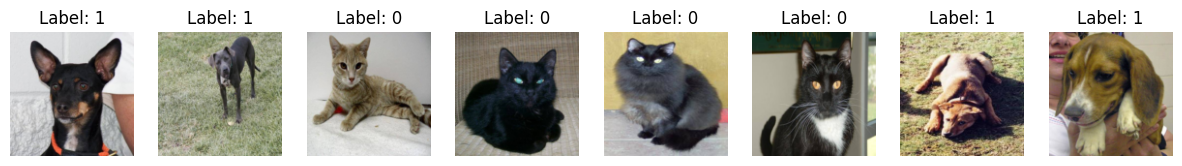

In [689]:

# Define the number of images to display
num_images = 8 # you can adjust this based on the batch size

# Plot the images in a grid
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    img = images[i].numpy().transpose((1, 2, 0))  # rearrange dimensions from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # ensure pixel values are between 0 and 1
    label = labels[i].item()  # get the label as a number

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.show()

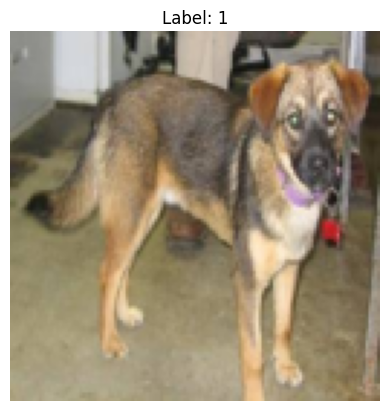

In [690]:
# Get a batch of data
images, labels = next(iter(train_loader))

# Select the first image and its corresponding label
image = images[0]  # Get the first image from the batch
label = labels[0].item()  # Get the corresponding label

# Convert the image from a tensor to a NumPy array
img = image.numpy().transpose((1, 2, 0))  # Rearrange dimensions from (C, H, W) to (H, W, C)
img = np.clip(img, 0, 1)  # Ensure pixel values are between 0 and 1

# Display the image
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")  # Hide the axis
plt.show()  # Show the plot

## Model

In [691]:
images.shape

torch.Size([30, 3, 128, 128])

In [692]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),padding=1,stride=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(3,3),padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(2,2),padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)) ##32 *32 *64
        )
        
        self.ann = nn.Sequential(
            nn.Linear((32 * 32 * 64), 120),
            nn.ReLU(),
            nn.Linear(120, output_size),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.cnn(x)
        x = x.view(x.shape[0],-1)
        x = self.ann(x)
        
        return x
        

## Training Loop

In [693]:
model = CustomCNN().to(device = device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)
acc =Accuracy(task = 'binary',threshold=0.5).to(device = device)

In [698]:
for epoch in range(epochs):
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    running_loss = 0.0
    for idx,(images,labels) in loop:
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        model.train()
        optimizer.zero_grad()
        
        output = model(images)
        labels = labels.unsqueeze(1).float()
        loss = criterion(output,labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        accuracy  = acc(output, labels).to(device = device)
        
        loop.set_description(f"Epoch : [{epoch}/{epochs}]")
        loop.set_postfix(loss =  loss.item(), accuracy = accuracy.item())
    
    ## print loss for each epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")
        

Epoch : [0/10]: 100%|██████████| 667/667 [01:25<00:00,  7.80it/s, accuracy=0.45, loss=0.693] 


Epoch [1/10], Loss: 0.6931


Epoch : [1/10]: 100%|██████████| 667/667 [01:30<00:00,  7.36it/s, accuracy=0.55, loss=0.693] 


Epoch [2/10], Loss: 0.6931


Epoch : [2/10]: 100%|██████████| 667/667 [01:46<00:00,  6.28it/s, accuracy=0.3, loss=0.693]  


Epoch [3/10], Loss: 0.6931


Epoch : [3/10]: 100%|██████████| 667/667 [01:29<00:00,  7.45it/s, accuracy=0.45, loss=0.693] 


Epoch [4/10], Loss: 0.6931


Epoch : [4/10]: 100%|██████████| 667/667 [01:27<00:00,  7.58it/s, accuracy=0.45, loss=0.693] 


Epoch [5/10], Loss: 0.6932


Epoch : [5/10]: 100%|██████████| 667/667 [01:26<00:00,  7.75it/s, accuracy=0.6, loss=0.693]  


Epoch [6/10], Loss: 0.6931


Epoch : [6/10]: 100%|██████████| 667/667 [01:25<00:00,  7.80it/s, accuracy=0.35, loss=0.693] 


Epoch [7/10], Loss: 0.6931


Epoch : [7/10]: 100%|██████████| 667/667 [01:25<00:00,  7.76it/s, accuracy=0.5, loss=0.693]  


Epoch [8/10], Loss: 0.6931


Epoch : [8/10]: 100%|██████████| 667/667 [01:27<00:00,  7.66it/s, accuracy=0.5, loss=0.693]  


Epoch [9/10], Loss: 0.6931


Epoch : [9/10]: 100%|██████████| 667/667 [01:28<00:00,  7.52it/s, accuracy=0.55, loss=0.693] 

Epoch [10/10], Loss: 0.6931


In [710]:
    # Validation Phase
model.eval()  # Set the model to evaluation mode
val_accuracy = Accuracy(task='binary', threshold=0.5).to(device=device)
val_loss = 0.0
val_accuracy_sum = 0.0

with torch.no_grad(): 
        for epoch in range(epochs):
            val_loop = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Validation Epoch [{epoch + 1}/{epochs}]") 
            for val_idx, (val_images, val_labels) in val_loop:
                val_images = val_images.to(device=device)
                val_labels = val_labels.to(device=device)
            
                val_output = model(val_images)
                val_labels = val_labels.unsqueeze(1).float()  # Ensure labels shape is correct
            
                v_loss = criterion(val_output, val_labels)
                val_loss += v_loss.item()
                val_accuracy_sum += val_accuracy(val_output, val_labels).item()
            
                val_loop.set_postfix(val_loss=v_loss.item(), val_accuracy=val_accuracy_sum / (val_idx + 1))

    # Average validation loss and accuracy
avg_val_loss = val_loss / len(val_loader)
avg_val_accuracy = val_accuracy_sum / len(val_loader)

Validation Epoch [10/10]: 100%|██████████| 167/167 [00:11<00:00, 14.28it/s, val_accuracy=5, val_loss=0.693]   
